In [117]:
%pip install -U langgraph langchain-google-genai geopy requests python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:

# Imports
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import geopy
from geopy.geocoders import Nominatim
import requests

In [85]:
from rag import OllamaEmbeddingGenerator, SimpleVectorSearch

In [95]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [98]:
api_key = os.getenv("GEMINI_API_KEY")

In [99]:
def create_llm(model: str = "gemini-2.5-flash", temperature: float = 1.0, max_retries: int = 2):
    """
    Create a LLM class
    
    Args:
        model: The model to use
        temperature: The temperature to use
        max_retries: The maximum number of retries
    
    Returns:
        A LLM class
    """
    return ChatGoogleGenerativeAI(
        model= model,
        temperature=temperature,
        max_retries=max_retries,
        google_api_key=api_key,
    )

In [100]:
embeddings = OllamaEmbeddingGenerator().load_embeddings("hec_outline_embeddings.json")

vector_search = SimpleVectorSearch(embeddings['embeddings'], embeddings['texts'])
print("🔍 Vector search initialized!")

📂 Embeddings loaded from hec_outline_embeddings.json
✅ Vector search initialized with 381 documents
🔍 Vector search initialized!


In [101]:
# Initialize geolocator
geolocator = Nominatim(user_agent="multi_agent")

# ============================================================================
# TOOL 1: WEATHER TOOL
# ============================================================================
def get_weather(location: str):
    """
    Get the current weather for a location
    """
    try:
        # Get the location coordinates
        location_obj = geolocator.geocode(location)
        if not location_obj:
            return f"Location '{location}' not found"
        
        response = requests.get(f"https://api.open-meteo.com/v1/forecast?latitude={location_obj.latitude}&longitude={location_obj.longitude}&current_weather=true")
        data = response.json()
        weather = data["current_weather"]
        return weather
    except Exception as e:
        return f"Error getting weather: {e}"

# ============================================================================
# TOOL 6: CRYPTOCURRENCY TOOL
# ============================================================================
def get_crypto_price(symbol: str = "bitcoin"):
    """
    Get current cryptocurrency price
    Common symbols: bitcoin, ethereum, litecoin, dogecoin, etc.
    """
    try:
        # Using CoinGecko API (free)
        symbol = symbol.lower()
        response = requests.get(f"https://api.coingecko.com/api/v3/simple/price?ids={symbol}&vs_currencies=usd")
        if response.status_code == 200:
            data = response.json()
            if symbol in data:
                return {
                    "cryptocurrency": symbol.title(),
                    "price_usd": data[symbol]["usd"],
                    "timestamp": "current"
                }
            else:
                return f"Cryptocurrency '{symbol}' not found"
        else:
            return f"Failed to get crypto price: HTTP {response.status_code}"
    except Exception as e:
        return f"Error getting crypto price: {e}"

def search_in_knowledge_base(query: str):
    """
    Search the knowledge base for the query
    """
    embedding_generator = OllamaEmbeddingGenerator()
    return vector_search.search_by_text(query, embedding_generator, top_k=5)

In [102]:
# System prompt
system_prompt = """
You are a multi-purpose assistant agent with access to various tools. You can help with:

1. 🌤️ WEATHER: Get current weather for any location
2. 💰 CRYPTO: Get current cryptocurrency prices
3. 📚 KNOWLEDGE BASE: Search the knowledge base for the query this tool is capable of searching related to course outline of Pakistan Universities.

Use the appropriate tool based on what the user is asking for. Be helpful and provide clear, formatted responses.
"""

In [ ]:

# Create the multi-tool agent
all_tools = [
    get_weather,
    get_crypto_price,
    search_in_knowledge_base,
]

agent = create_react_agent(
    model=create_llm(),
    tools=all_tools,
    prompt=system_prompt
)

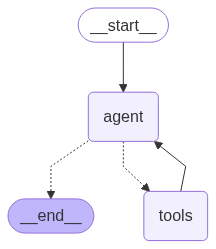

In [121]:
from IPython.display import Image

# Compile the state graph
graph = agent
Image(graph.get_graph().draw_mermaid_png())

In [126]:
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image, display

def draw_invocation_graph(path, filename="invocation.png"):
    """
    Draw a directed graph showing the actual path taken by the agent.
    
    Args:
        path: The path taken by the agent
        filename: The filename to save the image
    """
    G = nx.DiGraph()
    
    # Add edges for each consecutive step
    for i in range(len(path)-1):
        G.add_edge(path[i], path[i+1])
    
    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos, with_labels=True, node_size=2500, node_color="lightgreen", 
        arrows=True, font_size=10, font_weight="bold"
    )
    plt.title("Agent Invocation Path", fontsize=14)
    plt.show()

In [128]:
def stream_conversation(agent, user_message):
    """
    Stream the conversation with the agent
    
    Args:
        agent: The agent to use
        user_message: The message to send to the agent
        
    Returns:
        None
    """
    path = ["User", "Agent"]
    
    print("=" * 70)
    print("🎬 MULTI-TOOL AGENT - REAL CONVERSATION")
    print("=" * 70)
    
    print(f"\n👤 USER:")
    print(f"   {user_message}")
    
    result = agent.invoke({"messages": [("user", user_message)]})
    
    for message in result["messages"]:
        if message.__class__.__name__ == 'AIMessage':
            if hasattr(message, 'tool_calls') and message.tool_calls:
                for tool_call in message.tool_calls:
                    tool_name = tool_call['name']
                    print(f"🔧 Calling tool: {tool_name} with {tool_call['args']}")
                    
                    # Add tool node to path
                    path.append(tool_name)
                    path.append("Agent")
            elif message.content:
                print(f"\n🤖 AI: {message.content}")
                path.append("User")
        elif message.__class__.__name__ == 'ToolMessage':
            print(f"🔧 TOOL RESPONSE: {message.content}")
    
    print("=" * 70)
    print("✅ CONVERSATION COMPLETE")
    print("=" * 70)
    
    # Draw the invocation path as graph
    draw_invocation_graph(path)

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What's the weather in Islamabad?
🔧 Calling tool: get_weather with {'location': 'Islamabad'}
🔧 TOOL RESPONSE: {"time": "2025-09-15T10:15", "interval": 900, "temperature": 34.5, "windspeed": 7.7, "winddirection": 221, "is_day": 1, "weathercode": 2}

🤖 AI: The current weather in Islamabad is 34.5°C with a wind speed of 7.7 km/h and wind direction of 221°. It's currently day time.
✅ CONVERSATION COMPLETE


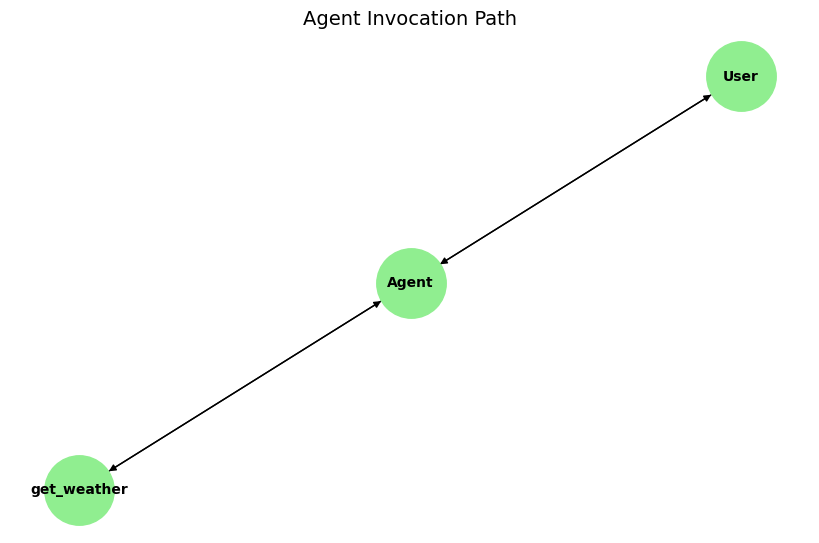

In [ ]:
stream_conversation(agent, "What's the weather in Islamabad?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What's the price of Etherium?
🔧 Calling tool: get_crypto_price with {'symbol': 'ethereum'}
🔧 TOOL RESPONSE: {"cryptocurrency": "Ethereum", "price_usd": 4520.39, "timestamp": "current"}

🤖 AI: The current price of Ethereum is $4520.39.
✅ CONVERSATION COMPLETE


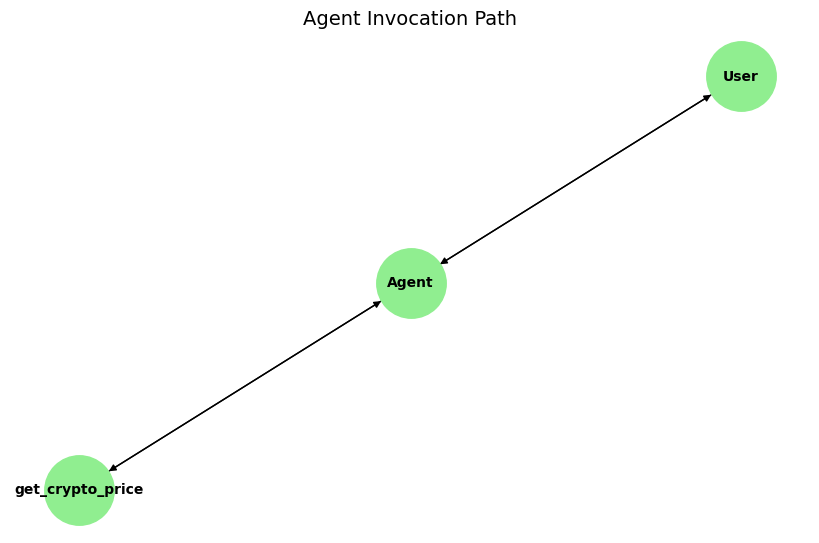

In [130]:
stream_conversation(agent, "What's the price of Etherium?")

🎬 MULTI-TOOL AGENT - REAL CONVERSATION

👤 USER:
   What is the pre-requisite for MSCS?
🔧 Calling tool: search_in_knowledge_base with {'query': 'What is the pre-requisite for MSCS?'}
🔧 TOOL RESPONSE: [{'text': '. The purpose is to indicate pre-requisite courses for studying advanced courses', 'similarity': 0.683333909486627, 'index': 51}, {'text': '. Students will be able to think creatively and critically; to solve non-trivial problems 3. Students will be able to use computing knowledge to develop efficient solutions for real life problems 4. Students will be able to design solutions and can conduct research related activities Eligibility: Degree in relevant subject, earned from a recognized university after 16 years of education with at least 60% marks or CGPA of at least 2.0 (on a scale of 4.0). The following core courses are recommended to be completed before entering the MS (CS) program. 1. Analysis of Algorithms 2. Assembly Lang. / Computer Architecture 3. Computer Networks 4. Com

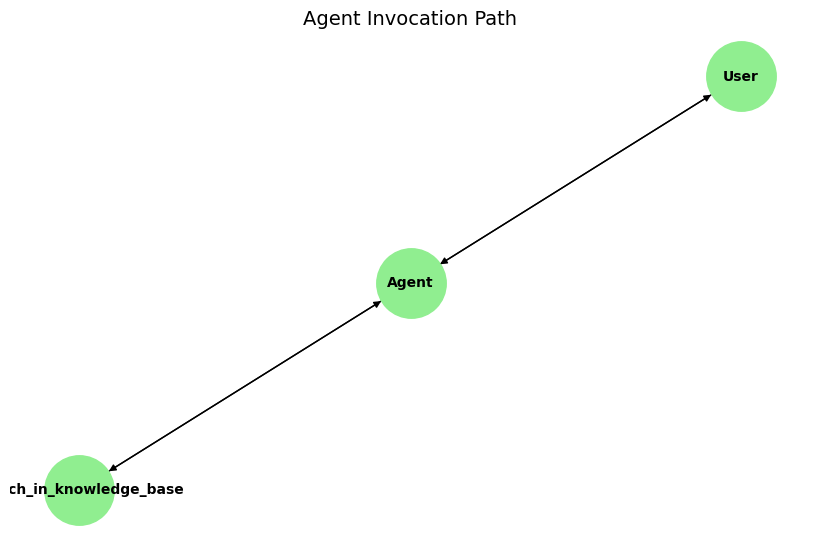

In [131]:
stream_conversation(agent, "What is the pre-requisite for MSCS?")